In [16]:
import os
import sys
import time
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import umap
import glob


import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.font_manager as font_manager
import seaborn as sns
import random
import math

os.chdir("/net/seq/data2/projects/aabisheva/Encode/my_ipynb/")

#import sklearn
#print(sklearn.__version__)

import sklearn.decomposition as skd
from sklearn.decomposition._nmf import _BaseNMF, _beta_loss_to_float, _initialize_nmf, _beta_divergence, _fit_coordinate_descent

from abc import ABC
from numbers import Integral, Real
import numpy as np
import scipy.sparse as sp
import time
import itertools
import warnings
from math import sqrt
from scipy import linalg


#from ._cdnmf_fast import _update_cdnmf_fast
from sklearn._config import config_context
from sklearn.base import BaseEstimator, TransformerMixin, ClassNamePrefixFeaturesOutMixin
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import check_random_state, check_array, gen_batches
from sklearn.utils.extmath import randomized_svd, safe_sparse_dot, squared_norm
from sklearn.utils.validation import (
    check_is_fitted,
    check_non_negative,
)
from sklearn.utils._param_validation import (
    Interval,
    StrOptions,
    validate_params,
)
EPSILON = np.finfo(np.float32).eps

sys.path.append('/net/seq/data2/projects/aabisheva/Encode/my_ipynb/Vocabulary')
import OONMF
import OONMFhelpers
from OONMFhelpers import get_barsortorder

plt.style.use('seaborn-v0_8-whitegrid')

/home/aabisheva/anaconda3/envs/pandasand/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aabisheva/anaconda3/envs/pandasand/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aabisheva/anaconda3/envs/pandasand/lib/python3.10/si

In [6]:
class NMF(_BaseNMF):
    _parameter_constraints: dict = {
        **_BaseNMF._parameter_constraints,
        "solver": [StrOptions({"mu", "cd"})],
        "shuffle": ["boolean"],
    }

    def __init__(
        self,
        n_components=None,
        *,
        init=None,
        solver="cd",
        beta_loss="frobenius",
        tol=1e-4,
        max_iter=200,
        random_state=None,
        alpha_W=0.0,
        alpha_H="same",
        l1_ratio=0.0,
        verbose=0,
        shuffle=False,
    ):
        super().__init__(
            n_components=n_components,
            init=init,
            beta_loss=beta_loss,
            tol=tol,
            max_iter=max_iter,
            random_state=random_state,
            alpha_W=alpha_W,
            alpha_H=alpha_H,
            l1_ratio=l1_ratio,
            verbose=verbose,
        )

        self.solver = solver
        self.shuffle = shuffle

    def _check_params(self, X):
        super()._check_params(X)

        # solver
        if self.solver != "mu" and self.beta_loss not in (2, "frobenius"):
            # 'mu' is the only solver that handles other beta losses than 'frobenius'
            raise ValueError(
                f"Invalid beta_loss parameter: solver {self.solver!r} does not handle "
                f"beta_loss = {self.beta_loss!r}"
            )
        if self.solver == "mu" and self.init == "nndsvd":
            warnings.warn(
                (
                    "The multiplicative update ('mu') solver cannot update "
                    "zeros present in the initialization, and so leads to "
                    "poorer results when used jointly with init='nndsvd'. "
                    "You may try init='nndsvda' or init='nndsvdar' instead."
                ),
                UserWarning,
            )

        return self

    def fit_transform(self, X, y=None, W=None, H=None, weights=None):

        self._validate_params()

        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32]
        )
        if weights is not None and self.beta_loss != 'frobenius':
            raise NotImplementedError
        with config_context(assume_finite=True):
            W, H, n_iter = self._fit_transform(X, W=W, H=H, weights=weights)

        self.reconstruction_err_ = _beta_divergence(
            X, W, H, self._beta_loss, square_root=True, weights=weights
        )

        self.n_components_ = H.shape[0]
        self.components_ = H
        self.n_iter_ = n_iter

        return W

    def _fit_transform(self, X, y=None, W=None, H=None, update_H=True, weights=None):
        check_non_negative(X, "NMF (input X)")

        # check parameters
        self._check_params(X)

        if X.min() == 0 and self._beta_loss <= 0:
            raise ValueError(
                "When beta_loss <= 0 and X contains zeros, "
                "the solver may diverge. Please add small values "
                "to X, or use a positive beta_loss."
            )

        # initialize or check W and H
        W, H = self._check_w_h(X, W, H, update_H)
        # scale the regularization terms
        l1_reg_W, l1_reg_H, l2_reg_W, l2_reg_H = self._compute_regularization(X)

        if self.solver == "cd":
            W, H, n_iter = _fit_coordinate_descent(
                X,
                W,
                H,
                self.tol,
                self.max_iter,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H=update_H,
                verbose=self.verbose,
                shuffle=self.shuffle,
                random_state=self.random_state,
            )
        elif self.solver == "mu":
            W, H, n_iter, *_ = _fit_multiplicative_update(
                X,
                W,
                H,
                self._beta_loss,
                self.max_iter,
                self.tol,
                l1_reg_W,
                l1_reg_H,
                l2_reg_W,
                l2_reg_H,
                update_H,
                self.verbose,
                weights=weights
            )
        else:
            raise ValueError("Invalid solver parameter '%s'." % self.solver)

        if n_iter == self.max_iter and self.tol > 0:
            warnings.warn(
                "Maximum number of iterations %d reached. Increase "
                "it to improve convergence."
                % self.max_iter,
                ConvergenceWarning,
            )

        return W, H, n_iter

    def transform(self, X):
        check_is_fitted(self)
        X = self._validate_data(
            X, accept_sparse=("csr", "csc"), dtype=[np.float64, np.float32], reset=False
        )

        with config_context(assume_finite=True):
            W, *_ = self._fit_transform(X, H=self.components_, update_H=False)

        return W
    
    
    
def _fit_multiplicative_update(
    X,
    W,
    H,
    beta_loss="frobenius",
    max_iter=200,
    tol=1e-4,
    l1_reg_W=0,
    l1_reg_H=0,
    l2_reg_W=0,
    l2_reg_H=0,
    update_H=True,
    verbose=0,
    weights=None
):
    start_time = time.time()

    beta_loss = _beta_loss_to_float(beta_loss)

    # gamma for Maximization-Minimization (MM) algorithm [Fevotte 2011]
    if beta_loss < 1:
        gamma = 1.0 / (2.0 - beta_loss)
    elif beta_loss > 2:
        gamma = 1.0 / (beta_loss - 1.0)
    else:
        gamma = 1.0

    # used for the convergence criterion
    error_at_init = _beta_divergence(X, W, H, beta_loss, square_root=True, weights=weights)
    previous_error = error_at_init

    H_sum, HHt, XHt = None, None, None
    if weights is None:
        wX = X
    else:
        if sp.issparse(X):
            wX = X.multiply(weights[:, None])
        else:
            wX = X * weights[:, None]
    for n_iter in range(1, max_iter + 1):
        # update W
        # H_sum, HHt and XHt are saved and reused if not update_H
        W, H_sum, HHt, XHt = _multiplicative_update_w(
            wX,
            W,
            H,
            beta_loss=beta_loss,
            l1_reg_W=l1_reg_W,
            l2_reg_W=l2_reg_W,
            gamma=gamma,
            H_sum=H_sum,
            HHt=HHt,
            XHt=XHt,
            update_H=update_H,
            weights=weights
        )

        # necessary for stability with beta_loss < 1
        if beta_loss < 1:
            W[W < np.finfo(np.float64).eps] = 0.0

        # update H (only at fit or fit_transform)
        if update_H:
            H = _multiplicative_update_h(
                wX,
                W,
                H,
                beta_loss=beta_loss,
                l1_reg_H=l1_reg_H,
                l2_reg_H=l2_reg_H,
                gamma=gamma,
                weights=weights
            )

            # These values will be recomputed since H changed
            H_sum, HHt, XHt = None, None, None

            # necessary for stability with beta_loss < 1
            if beta_loss <= 1:
                H[H < np.finfo(np.float64).eps] = 0.0

        # test convergence criterion every 10 iterations
        if tol > 0 and n_iter % 10 == 0:
            error = _beta_divergence(X, W, H, beta_loss, square_root=True, weights=weights)

            if verbose:
                iter_time = time.time()
                print(
                    "Epoch %02d reached after %.3f seconds, error: %f"
                    % (n_iter, iter_time - start_time, error)
                )

            if (previous_error - error) / error_at_init < tol:
                break
            previous_error = error

    # do not print if we have already printed in the convergence test
    if verbose and (tol == 0 or n_iter % 10 != 0):
        end_time = time.time()
        print(
            "Epoch %02d reached after %.3f seconds." % (n_iter, end_time - start_time)
        )

    return W, H, n_iter

def _multiplicative_update_w(
    X,
    W,
    H,
    beta_loss,
    l1_reg_W,
    l2_reg_W,
    gamma,
    H_sum=None,
    HHt=None,
    XHt=None,
    update_H=True,
    weights=None
):
    """Update W in Multiplicative Update NMF."""
    if beta_loss == 2:
        # Numerator
        if XHt is None:
            XHt = safe_sparse_dot(X, H.T)
        if update_H:
            # avoid a copy of XHt, which will be re-computed (update_H=True)
            numerator = XHt
        else:
            # preserve the XHt, which is not re-computed (update_H=False)
            numerator = XHt.copy()

        # Denominator
        if HHt is None:
            HHt = np.dot(H, H.T)

        if weights is None:
            denominator = np.dot(W, HHt)
        else:
            denominator = np.dot(weights[:, None] * W, HHt)
    else:
        if weights is not None:
            raise NotImplementedError
        # Numerator
        # if X is sparse, compute WH only where X is non zero
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH < EPSILON] = EPSILON

        # to avoid taking a negative power of zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data < EPSILON] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(X * (dot(W, H) ** (beta_loss - 2)), H.T)
        numerator = safe_sparse_dot(WH_safe_X, H.T)

        # Denominator
        if beta_loss == 1:
            if H_sum is None:
                H_sum = np.sum(H, axis=1)  # shape(n_components, )
            denominator = H_sum[np.newaxis, :]

        else:
            # computation of WHHt = dot(dot(W, H) ** beta_loss - 1, H.T)
            if sp.issparse(X):
                # memory efficient computation
                # (compute row by row, avoiding the dense matrix WH)
                WHHt = np.empty(W.shape)
                for i in range(X.shape[0]):
                    WHi = np.dot(W[i, :], H)
                    if beta_loss - 1 < 0:
                        WHi[WHi < EPSILON] = EPSILON
                    WHi **= beta_loss - 1
                    WHHt[i, :] = np.dot(WHi, H.T)
            else:
                WH **= beta_loss - 1
                WHHt = np.dot(WH, H.T)
            denominator = WHHt

    # Add L1 and L2 regularization
    if l1_reg_W > 0:
        denominator += l1_reg_W
    if l2_reg_W > 0:
        denominator = denominator + l2_reg_W * W
    denominator[denominator == 0] = EPSILON

    numerator /= denominator
    delta_W = numerator

    # gamma is in ]0, 1]
    if gamma != 1:
        delta_W **= gamma

    W *= delta_W

    return W, H_sum, HHt, XHt


def _multiplicative_update_h(
    X, W, H, beta_loss, l1_reg_H, l2_reg_H, gamma, A=None, B=None, rho=None, weights=None
):
    """update H in Multiplicative Update NMF."""
    if beta_loss == 2:
        numerator = safe_sparse_dot(W.T, X)
        if weights is None:
            denominator = np.linalg.multi_dot([W.T, W, H])
        else:
            denominator = np.linalg.multi_dot([W.T, weights[:, None] * W, H])

    else:
        # Numerator
        WH_safe_X = _special_sparse_dot(W, H, X)
        if sp.issparse(X):
            WH_safe_X_data = WH_safe_X.data
            X_data = X.data
        else:
            WH_safe_X_data = WH_safe_X
            X_data = X
            # copy used in the Denominator
            WH = WH_safe_X.copy()
            if beta_loss - 1.0 < 0:
                WH[WH < EPSILON] = EPSILON

        # to avoid division by zero
        if beta_loss - 2.0 < 0:
            WH_safe_X_data[WH_safe_X_data < EPSILON] = EPSILON

        if beta_loss == 1:
            np.divide(X_data, WH_safe_X_data, out=WH_safe_X_data)
        elif beta_loss == 0:
            # speeds up computation time
            # refer to /numpy/numpy/issues/9363
            WH_safe_X_data **= -1
            WH_safe_X_data **= 2
            # element-wise multiplication
            WH_safe_X_data *= X_data
        else:
            WH_safe_X_data **= beta_loss - 2
            # element-wise multiplication
            WH_safe_X_data *= X_data

        # here numerator = dot(W.T, (dot(W, H) ** (beta_loss - 2)) * X)
        numerator = safe_sparse_dot(W.T, WH_safe_X)

        # Denominator
        if beta_loss == 1:
            W_sum = np.sum(W, axis=0)  # shape(n_components, )
            W_sum[W_sum == 0] = 1.0
            denominator = W_sum[:, np.newaxis]

        # beta_loss not in (1, 2)
        else:
            # computation of WtWH = dot(W.T, dot(W, H) ** beta_loss - 1)
            if sp.issparse(X):
                # memory efficient computation
                # (compute column by column, avoiding the dense matrix WH)
                WtWH = np.empty(H.shape)
                for i in range(X.shape[1]):
                    WHi = np.dot(W, H[:, i])
                    if beta_loss - 1 < 0:
                        WHi[WHi < EPSILON] = EPSILON
                    WHi **= beta_loss - 1
                    WtWH[:, i] = np.dot(W.T, WHi)
            else:
                WH **= beta_loss - 1
                WtWH = np.dot(W.T, WH)
            denominator = WtWH

    # Add L1 and L2 regularization
    if l1_reg_H > 0:
        denominator += l1_reg_H
    if l2_reg_H > 0:
        denominator = denominator + l2_reg_H * H
    denominator[denominator == 0] = EPSILON

    if A is not None and B is not None:
        # Updates for the online nmf
        if gamma != 1:
            H **= 1 / gamma
        numerator *= H
        A *= rho
        B *= rho
        A += numerator
        B += denominator
        H = A / B

        if gamma != 1:
            H **= gamma
    else:
        delta_H = numerator
        delta_H /= denominator
        if gamma != 1:
            delta_H **= gamma
        H *= delta_H

    return H


def _beta_divergence(X, W, H, beta, square_root=False, weights=None):
    beta = _beta_loss_to_float(beta)

    # The method can be called with scalars
    if not sp.issparse(X):
        X = np.atleast_2d(X)
    W = np.atleast_2d(W)
    H = np.atleast_2d(H)

    # Frobenius norm
    if beta == 2:
        # Avoid the creation of the dense np.dot(W, H) if X is sparse.
        if sp.issparse(X):
            if weights is not None:
                raise NotImplementedError()
            norm_X = np.dot(X.data, X.data)
            norm_WH = trace_dot(np.linalg.multi_dot([W.T, W, H]), H)
            cross_prod = trace_dot((X * H.T), W)
            res = (norm_X + norm_WH - 2.0 * cross_prod) / 2.0
        else:
            if weights is None:
                res = squared_norm(X - np.dot(W, H)) / 2.0
            else:
               
                K = np.ravel((X - np.dot(W, H)) * np.sqrt(weights[:, None]))
                res = np.dot(K, K) / 2.0

        if square_root:
            return np.sqrt(res * 2)
        else:
            return res
    if weights is not None:
        raise NotImplementedError()
    if sp.issparse(X):
        # compute np.dot(W, H) only where X is nonzero
        WH_data = _special_sparse_dot(W, H, X).data
        X_data = X.data
    else:
        WH = np.dot(W, H)
        WH_data = WH.ravel()
        X_data = X.ravel()

    # do not affect the zeros: here 0 ** (-1) = 0 and not infinity
    indices = X_data > EPSILON
    WH_data = WH_data[indices]
    X_data = X_data[indices]

    # used to avoid division by zero
    WH_data[WH_data < EPSILON] = EPSILON

    # generalized Kullback-Leibler divergence
    if beta == 1:
        # fast and memory efficient computation of np.sum(np.dot(W, H))
        sum_WH = np.dot(np.sum(W, axis=0), np.sum(H, axis=1))
        # computes np.sum(X * log(X / WH)) only where X is nonzero
        div = X_data / WH_data
        res = np.dot(X_data, np.log(div))
        # add full np.sum(np.dot(W, H)) - np.sum(X)
        res += sum_WH - X_data.sum()

    # Itakura-Saito divergence
    elif beta == 0:
        div = X_data / WH_data
        res = np.sum(div) - np.prod(X.shape) - np.sum(np.log(div))

    # beta-divergence, beta not in (0, 1, 2)
    else:
        if sp.issparse(X):
            # slow loop, but memory efficient computation of :
            # np.sum(np.dot(W, H) ** beta)
            sum_WH_beta = 0
            for i in range(X.shape[1]):
                sum_WH_beta += np.sum(np.dot(W, H[:, i]) ** beta)

        else:
            sum_WH_beta = np.sum(WH**beta)

        sum_X_WH = np.dot(X_data, WH_data ** (beta - 1))
        res = (X_data**beta).sum() - beta * sum_X_WH
        res += sum_WH_beta * (beta - 1)
        res /= beta * (beta - 1)

    if square_root:
        res = max(res, 0)  # avoid negative number due to rounding errors
        return np.sqrt(2 * res)
    else:
        return res



In [7]:
def make_stacked_bar_plot_sorted(self, Nrelevant, BarMatrix, bargraph_out, names=[], barsortorder=[], plot_title='', figdim1=150, figdim2=40):
    if len(barsortorder) < 1:
        barsortorder = np.arange(Nrelevant)

    if len(names) < 1:
        names = [str(i) for i in range(Nrelevant)]
        names = np.array(names)

    start = 0
    end = Nrelevant
    Xpositions = np.arange(Nrelevant)

    self.define_colors()

    plt.clf()
    plt.figure(figsize=(figdim1, figdim2))

    for column in range(Nrelevant):
        ground_pSample = 0
        bar_heights = BarMatrix[:, start:end].T[barsortorder][column]
        indices = np.flip(np.argsort(bar_heights))
        # indices = np.arange(self.Ncomps)
        sorted_heights = bar_heights[indices]
        colours = [self.Comp_colors[i] for i in indices]

        for component in range(self.Ncomps):
            plt.bar(Xpositions[column], sorted_heights[component], bottom=ground_pSample, color=colours[component], alpha=1)
            ground_pSample = np.sum(sorted_heights[0:component + 1])

    OONMFhelpers.increase_axis_fontsize()

    plt.ylabel('sum of signal in matrix', fontsize=70)
    if (len(plot_title) > 0):
        plt.title(plot_title)

    samplenamesize = (1 / Nrelevant)**0.5 * 130
    thebottom = min([(1 / Nrelevant)**0.3 * 1.2, 0.3])

    plt.xticks(Xpositions, names[barsortorder], rotation='vertical', fontsize=samplenamesize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=thebottom)

    plt.savefig(bargraph_out)
    plt.show()
    plt.close()


OONMF.NMFobject.make_stacked_bar_plot_sorted = make_stacked_bar_plot_sorted

def barsortorder_all_components(BarMatrix):
    bar_indices = np.empty(BarMatrix.T.shape)
    for i, bar in enumerate(BarMatrix):
        np.copyto(bar_indices[:, i], np.flip(np.argsort(bar)))
    return np.lexsort(np.flip(bar_indices, 0))

def initialize_u_v(X, n_components,random_state = 0):
    n_features, n_samples = X.shape
    mean = np.mean(X)
    random_number_generator = np.random.RandomState(random_state)
    ## estimate density by partitioning mean across components
    est = np.sqrt(mean/n_components)

    ## generate entries of U/V using randn, scale by est
    U = est*random_number_generator.randn(n_features,n_components)
    np.abs(U,U) ## mutate in-place absolute value

    V = est*random_number_generator.randn(n_components,n_samples)
    np.abs(V,V) ## mutate in-place absolute value

    ## set all zeroes (if there are any) to epsmin
    epsmin = np.finfo(type(X[0,0])).eps
    V[V==0]=epsmin
    U[U==0]=epsmin                    

    return U,V

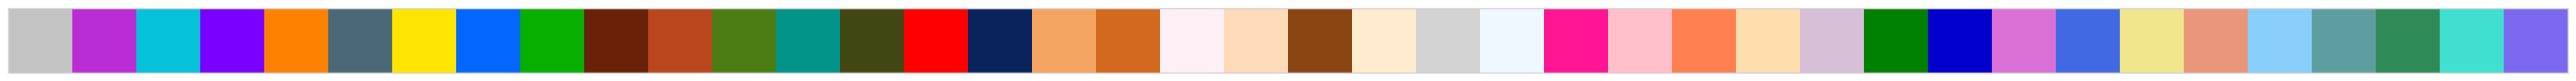

In [14]:
# Just color scheme inicialization

n_components = 40

# code from Waulter's library, to have the similar colors as in barplot
colors_order = ['#FFE500', '#FE8102', '#FF0000', '#07AF00', '#4C7D14', '#414613', '#05C1D9', '#0467FD', '#009588', '#BB2DD4', '#7A00FF', '#4A6876', '#08245B', '#B9461D', '#692108', '#C3C3C3']
neworder = np.array([16,10,7,11,2,12,1,8,4,15,14,5,9,6,3,13]).astype(int) - 1
colors_order = list(np.array(colors_order)[neworder])

if (n_components>len(colors_order)):
    colornames = np.sort(list(mcolors.CSS4_COLORS.keys()))
    count = len(colors_order)
    np.random.seed(10)
    myrandint = np.random.randint(len(colornames))
    while (count < n_components):
        myrandint =    np.random.randint(len(colornames))
        newcolor = colornames[myrandint]
        trialcount = 0
        while ((newcolor in colors_order) and (trialcount < 100)):
            newcolor = colornames[np.random.randint(0,len(colornames))]
            trialcount+=1
        #print('new color ',count,newcolor)
        colors_order.append(newcolor)
        count+=1

# just for checking colors
fig, ax = plt.subplots(figsize=(len(colors_order), 1))

# Draw a rectangle for each color in the list
for i, color in enumerate(colors_order):
    rect = plt.Rectangle((i, 0), 1, 1, facecolor=color, edgecolor='none')
    ax.add_patch(rect)

# Customize the plot
ax.set_xlim(0, len(colors_order))
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.show()

# Data loading

In [2]:
import gzip

with gzip.open('./Vocabulary/data/dat_bin_FDR01_hg38.txt.gz', 'rt') as f:
    A = np.loadtxt(f)

print(A.shape)

(3591898, 733)


In [3]:
n_components = 16

In [ ]:
# I recalculate Wouter results here, using our new function

In [8]:
start_time = time.time()
print("start")
model = NMF(n_components=n_components, solver='mu', beta_loss='frobenius', max_iter=1000, random_state=0, init="custom")
H, W = initialize_u_v(A, n_components)
W = model.fit_transform(A.T, W=W.T, H=H.T, weights=np.ones(A.shape[1]))
H = model.components_
end_time = time.time()
print("Time taken by fitting:", end_time - start_time, "seconds, n_components", n_components)


np.save("./Reprojection/733"+'.W_matrix.npy', W)
np.save("./Reprojection/733"+'.H_matrix.npy', H)

start
Time taken by fitting: 1846.6657679080963 seconds, n_components 16


In [12]:
# Load all this data in OONMF
decomp = OONMF.NMFobject(16)
decomp.matrix_input_name("./Reprojection/733"+'.W_matrix.npy', "./Reprojection/733"+'.H_matrix.npy')
decomp.read_matrix_input(compressed=False)


sampnamePD = pd.read_table('./Vocabulary/data/sampnams_733.txt', header=None, names=['LN', 'DS', 'type'])
sampnamePD['full_name'] = sampnamePD.LN + '-' + sampnamePD.DS + '-' + sampnamePD.type
fullnames = sampnamePD.full_name.values

bar_graph_sort_order = get_barsortorder(decomp.Basis)

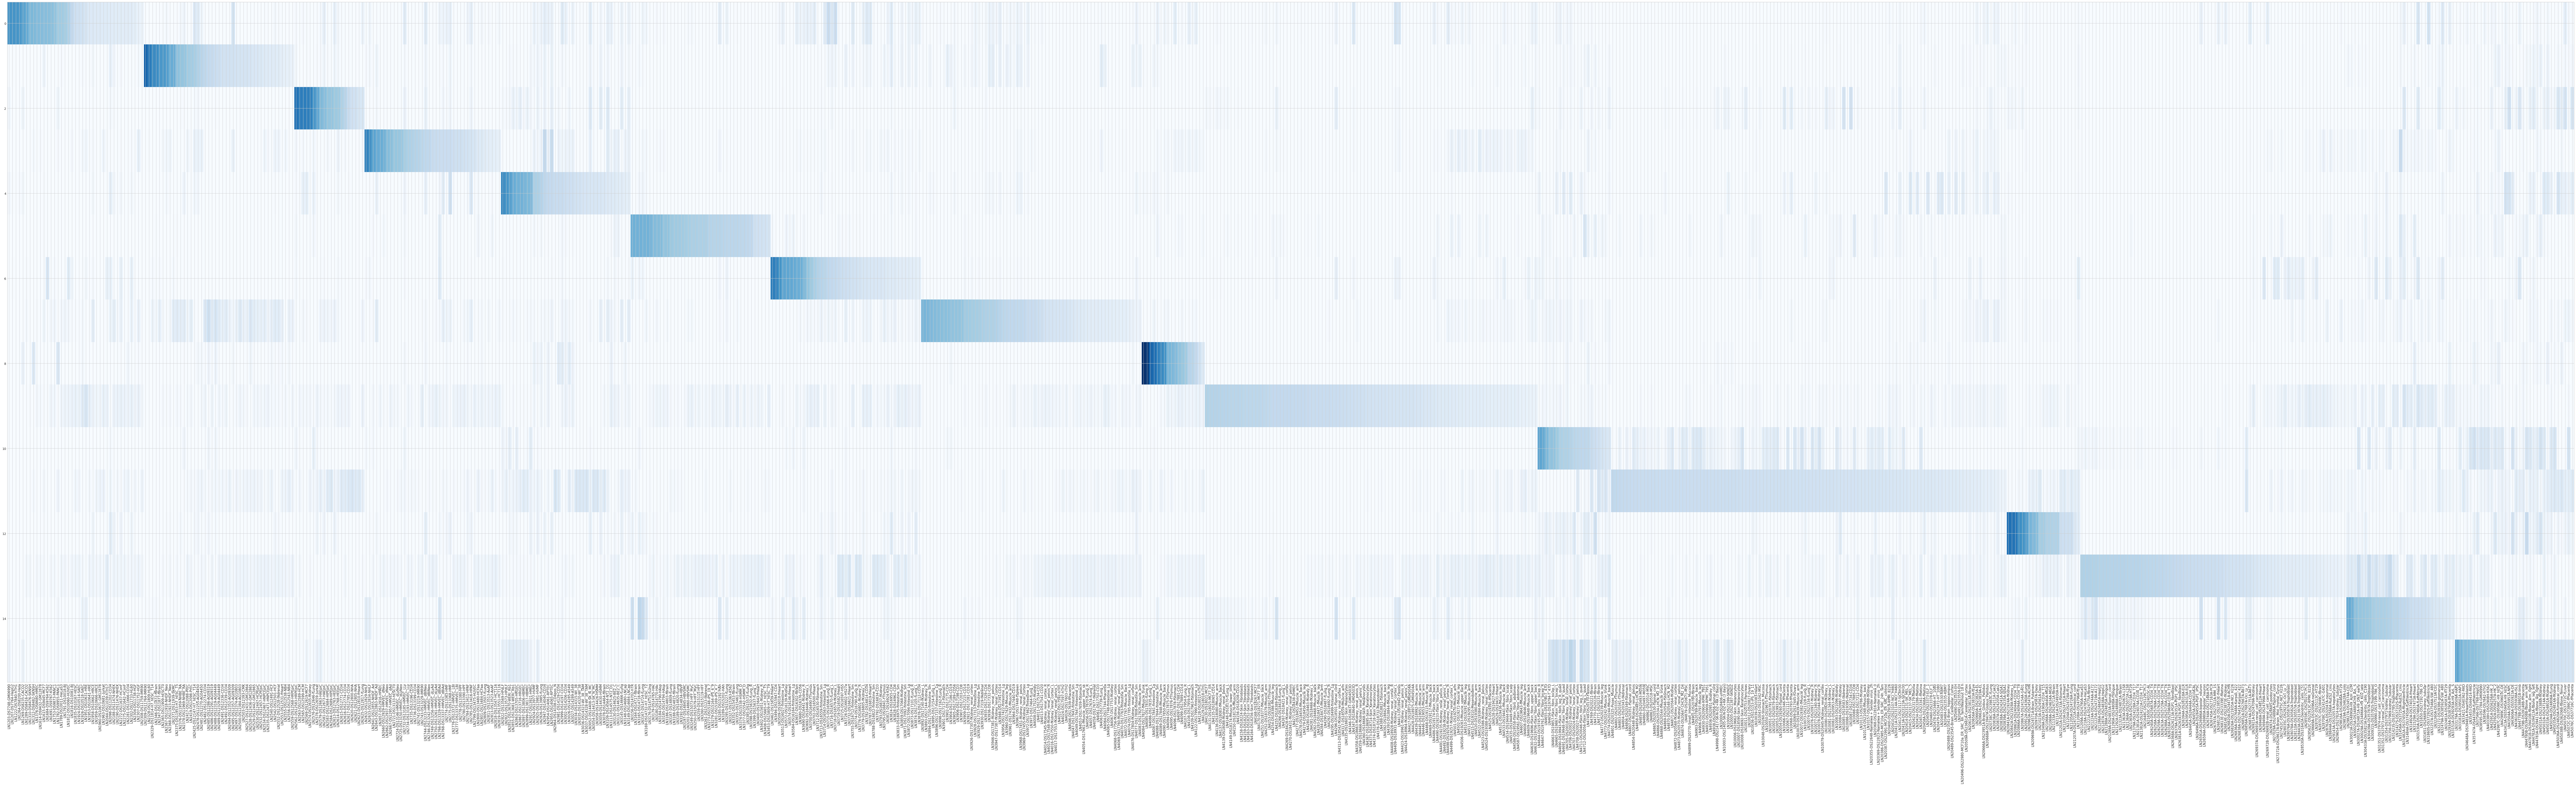

In [13]:
# check heatmap
decomp.make_standard_heatmap_plot(733, decomp.Basis, '', names=np.array(fullnames), barsortorder= bar_graph_sort_order)

<Figure size 640x480 with 0 Axes>

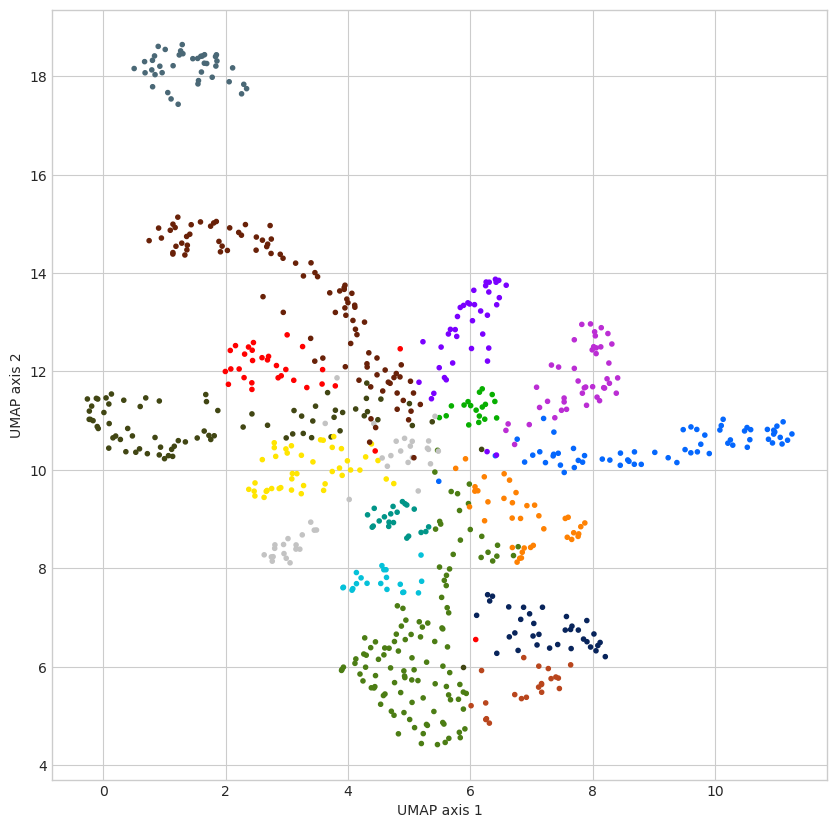

In [19]:
decomp.normalize_matrices()
decomp.define_colors()

reducer = umap.UMAP(min_dist=0.5, n_neighbors=200, random_state=33)
embedding = reducer.fit_transform(decomp.Basis)
majcomp = np.argmax(decomp.Basis, axis=1)
majcomp_no1 = np.argmax(decomp.Basis[:,1:], axis=1)+1

plt.clf()
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], color=np.array(decomp.Comp_colors)[majcomp], alpha=1, marker='.')
plt.ylabel('UMAP axis 2')
plt.xlabel('UMAP axis 1')
plt.show()

In [ ]:
# I looked in my Vocub 7 notebook, and there is a description of the process of obtaining encode4 data based on the old index.

dfs = []
for filename in glob.glob('/home/aabisheva/Dev/Encode/new_peak_data/new_peak_data_*.txt.gz'):
    df = pd.read_csv(filename, sep='\t', compression='gzip', header=None)
    dfs.append(df)

# Concatenate the dataframes horizontally
merged_df = pd.concat(dfs, axis=1).T
merged_df